## <font style="color:white">4.2. Prepare dataset files</font>
We need to create a txt file which contains the path to the images. These files will be used while setting up the training. 

The data is split into train and test in the ratio of 80:20. So, we will use 80% of the data for training and the rest for testing after a few iterations of training.

In [1]:
import random
import os
import subprocess
import sys

image_dir = "./mask_no-mask_dataset"
f_val = open("data_test.txt", 'w')
f_train = open("data_train.txt", 'w')

path, dirs, files = next(os.walk(image_dir))
data_size = len(files)

ind = 0
data_test_size = int(0.2 * data_size)
test_array = random.sample(range(data_size), k=data_test_size)

for f in os.listdir(image_dir):
    if(f.split(".")[-1] == "jpg"):
        ind += 1
        
        if ind in test_array:
            f_val.write(image_dir+'/'+f+'\n')
        else:
            f_train.write(image_dir+'/'+f+'\n')

f_train.close()
f_val.close()

In [8]:
# download weights, they're too big
!wget "https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1" -O darknet53.conv.74

--2022-04-18 09:18:39--  https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.7.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.7.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/18dwbfth7prbf0h/darknet53.conv.74 [following]
--2022-04-18 09:18:39--  https://www.dropbox.com/s/dl/18dwbfth7prbf0h/darknet53.conv.74
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc83acba1a6c25400030a6219de4.dl.dropboxusercontent.com/cd/0/get/BjrKDqk7PxYFq_GsZRlW0vNNfr8E5sftY37Sf2YAncq5rcD7nPVGgBXj8hOS_3aVDV_-ikomNzNNeRR_O0f7YOaUbGUeA7q1Tzgw9MZWrG9C5llVHDdLtS15spHKVEUNyqNO67ru1v-4Pbvv-hVHalYWBuusLqPrkiVnNMIDDZHhg4HZKFrRcDiFB2lpLBQAVU8/file?dl=1# [following]
--2022-04-18 09:18:40--  https://uc83acba1a6c25400030a6219de4.dl.dropboxusercontent.com/cd/0/get/BjrKDqk7PxYFq_GsZRlW0vNNfr8E5s

# <font style="color:white">7. Training Configuration</font>
As explained in the theory section, we will use the config file to specify the various training parameters. A gist of all the parameters is given below:

## <font style="color:white">7.1. Data Setup</font>
In the file **`yolov3-ambulance-setup.data`**(included in our code), we need to provide information about the specifications for our object detector and some relevant paths.

The contents of the file are as follows:
```
classes = 1
train  = data_train.txt
valid  = data_test.txt
names = class.names
backup = backup/
```
The classes parameter needs the number of classes. In our case, it is 1.

You need to provide the absolute paths of the files **`data_train.txt`** and **`data_test.txt`** generated earlier, which have the list of files to be used for training(train parameter) and validation(valid parameter) respectively.

The names field represents the path of a file which contains the names of all the classes. We have included the **`class.names`** file which contains the class name **`Ambulance`**. You will need to provide its absolute path in your machine here.

Lastly, for the **`backup`** parameter, we need to give the path to an existing directory where we can store the intermediate weights files as the training progresses.

## <font style="color:white">7.2. Training Config File</font>
Along with the yolov3-ambulance-setup.data and class.names files, YOLOv3 also needs a configuration file **`yolov3-ambulance-train.cfg`**. It is based on the demo configuration file, yolov3-voc.cfg (comes with darknet code), which was used to train on the VOC dataset. All the important training parameters are stored in this configuration file. Let us understand what they mean and what values to set them to.

### <font style="color:green">7.2.1 Batch hyper-parameter in YOLOv3</font>
Let’s learn more about batch and subdivision parameter.
```
[net]
# Testing
# batch=1
# subdivisions=1
# Training
batch=64
subdivisions=16
```
The batch parameter indicates the batch size used during training.

Our training set contains a few hundred images, but it is not uncommon to train on million of images. The training process involves iteratively updating the weights of the neural network based on how many mistakes it is making on the training dataset.

It is impractical (and unnecessary) to use all images in the training set at once to update the weights. So, a small subset of images is used in one iteration, and this subset is called the batch size.

When the batch size is set to 64, it means 64 images are used in one iteration to update the parameters of the neural network.

### <font style="color:green">7.2.2 Subdivisions configuration parameter in YOLOv3</font>
Even though you may want to use a batch size of 64 for training your neural network, you may not have a GPU with enough memory to use a batch size of 64. Fortunately, Darknet allows you to specify a variable called subdivisions that lets you process a fraction of the batch size at one time on your GPU.

You can start the training with subdivisions=1, and if you get an Out of memory error, increase the subdivisions parameter by multiples of 2(e.g. 2, 4, 8, 16) till the training proceeds successfully. The GPU will process batch/subdivision number of images at any time, but the full batch or iteration would be complete only after all the 64 (as set above) images are processed.

During testing, both batch and subdivision are set to 1.

### <font style="color:green">7.2.3 Width, Height, Channels</font>
These configuration parameters specify the input image size and the number of channels.

```
width=416
height=416
channels=3
```
The input training images are first resized to width x height before training. Here we use the default values of 416×416. The results might improve if we increase it to 608×608, but it would take longer to train too. channels=3 indicates that we would be processing 3-channel RGB input images.

### <font style="color:green">7.2.4 Momentum and Decay</font>
The configuration file contains a few parameters that control how the weight is updated.
```
momentum=0.9
decay=0.0005
```
In the previous section, we mentioned how the weights of a neural network are updated based on a small batch of images and not the entire dataset. Because of this reason, the weight updates fluctuate quite a bit. That is why a parameter momentum is used to penalize large weight changes between iterations.

A typical neural network has millions of weights and therefore they can easily overfit any training data. Overfitting simply means it will do very well on training data and poorly on test data. It is almost like the neural network has memorized the answer to all images in the training set, but really not learned the underlying concept. One of the ways to mitigate this problem is to penalize large value for weights. The parameter decay controls this penalty term. The default value works just fine, but you may want to tweak this if you notice overfitting.

### <font style="color:green">7.2.5 Learning Rate, Steps, Scales, Burn In (warm-up)</font>
```
learning_rate=0.001
policy=steps
steps=800
scales=.1
burn_in=100
```
The parameter learning rate controls how aggressively we should learn based on the current batch of data. Typically this is a number between 0.01 and 0.0001.

At the beginning of the training process, we are starting with zero information and so the learning rate needs to be high. But as the neural network sees a lot of data, the weights need to change less aggressively. In other words, the learning rate needs to be decreased over time. In the configuration file, this decrease in learning rate is accomplished by first specifying that our learning rate decreasing policy is steps. In the above example, the learning rate will start from 0.001 and remain constant for 800 iterations, and then it will multiply by scales to get the new learning rate. We could have also specified multiple steps and scales.

In the previous paragraph, we mentioned that the learning rate needs to be high in the beginning and low later on. While that statement is largely true, it has been empirically found that the training speed tends to increase if we have a lower learning rate for a short period of time at the very beginning. This is controlled by the burn_in parameter. Sometimes this **`burn-in`** period is also called warm-up period.

### <font style="color:green">7.2.6 Data augmentation</font>
We know data collection takes a long time and it is difficult to find high quality annotated data. We want to make maximum use of this data by cooking up new data. This process is called data augmentation. For example, an image of the ambulance rotated by 5 degrees is still an image of a ambulance. The angle parameter in the configuration file allows you to randomly rotate the given image by ± angle.

Similarly, if we transform the colors of the entire picture using saturation, exposure, and hue, it is still a picture of the ambulance.
```
angle=0
saturation = 1.5
exposure = 1.5
hue=.1
```
We used the default values for training.

### <font style="color:green">7.2.7 Number of iterations</font>
Finally, we need to specify how many iterations should the training process be run for.
```
max_batches=1000
```

For multi-class object detectors, the max_batches number is higher, i.e. we need to run for more number of batches(e.g. in yolov3-voc.cfg). For an n-classes object detector, it is advisable to run the training for at least 2000*n batches. In our case with only 1 class, 1000 seemed like a safe number for max_batches. 

You should try to change the parameter and see how it performs.

### <font style="color:green">7.2.8 Change filters parameter in conv layers [Important for multiple objects]</font>
Change the filters parameter in the convolutional layer just before the yolo layer according to the formula 

**`filters=( classes + 5 ) * 3`**

Since we are using classes = 1, thus, #filters in our case is 18. You should make this change if you are dealing with more classes.


## <font color="white">7.3. Names file </font>
We need to specify the names of the classes in the **`.names`** file. In our case, there is only 1 class and thus, only Ambulance is added to that file.

# <font style="color:white">8. Start Training </font>
For starting training using darknet, we need to execute the following command. Here we are specifying the
1. path to the setup file, 
1. path to config file, 
1. path to convolutional weights file 

and also passing some flags such as:

- **`dont_show`** which wont display the graphs. This is required for Colab since it does not have a display and it will crash if it tries to display, not if you run the notebook on your local system.
- **`map`** - this will calculate mAP - mean average precision for the test data which we have specified using the data_test.txt file which contains 20% of our data.

In [28]:
!/home/jeff/Documents/Code/darknet/darknet detector train yolov3-mask-setup.data yolov3-mask-train.cfg ./backup/yolov3-mask-train_last.weights -map 2> train_log.txt

 Prepare additional network for mAP calculation...
net.optimized_memory = 0 
mini_batch = 1, batch = 32, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 
yolov3-mask-train
net.optimized_memory = 0 
mini_batch = 2, batch = 64, time_steps = 1, train = 1 

 seen 64, trained: 211 K-images (3 Kilo-batches_64) 
Learning Rate: 0.001, Momentum: 0.9, Decay: 0.0005
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
 If error occurs - run training with flag: -dont_show 
Resizing, random_coef = 1.40 

 608 x 608 
 try to allocate additional workspace_size = 164.41 MB 
 CUDA allocate done! 
Loaded: 0.000046 seconds

 (next mAP calculation at 3400 iterations) ]2;3301/5000: loss=0.8 hours left=-1.0
 3301: 0.779075, 0.779075 avg loss, 0.001000 rate, 34.950330 seconds, 211264 images, -1.000000 hours left
Loaded: 0.000074 seconds

 (next mAP calculation at 3400 iterations) ]2;3302/5000: loss=0.4 hours left=16.5
 3302: 0.44

# <font style="color:white">Notes on Training</font>
From the above training process we can make the following observations:
1. The images are resized after every 10 iterations
It takes around 11 seconds per iteration which consists of 64 images for an image size of 576.
1. We can see that the training started very slowly in the first few iterations and then very gradually, the loss started reducing.
1. As we can see the learning rate increases gradually from 0 to 0.001 by the 100th batch ( burn_in was set to 100 ). It would stay there till the 1500th batch when it would again change to 0.0001.
1. mAP is calculated for every 100 iterations. It reaches >80% after 200 iterations.
1. You can check out the training graph for mAP v/s iterations which is saved in the file **chart.png**


# <font style="color:white">9. Perform Inference</font>
Finally, let us use the trained model to perform inference on some unseen images from the internet.

We have written a simple utility function which can be used to display the input and output similar to what we did in the previous section

We are already familiar with the inference code which we saw in the previous section.

In [18]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def display_output(imagePath):
    src = cv2.imread(imagePath,1)
    output = cv2.imread("predictions.jpg")

    plt.figure(figsize=[20,8])
    plt.subplot(121)
    plt.imshow(src[:,:,::-1])
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(output[:,:,::-1])
    plt.title("Predictions")
    plt.show()

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 

 seen 64, trained: 211 K-images (3 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
/home/jeff/Documents/Code/YOLO-Mask-Detector/yolo_test/test-image1.jpg: Predicted in 106.761000 milli-seconds.
Mask: 100%


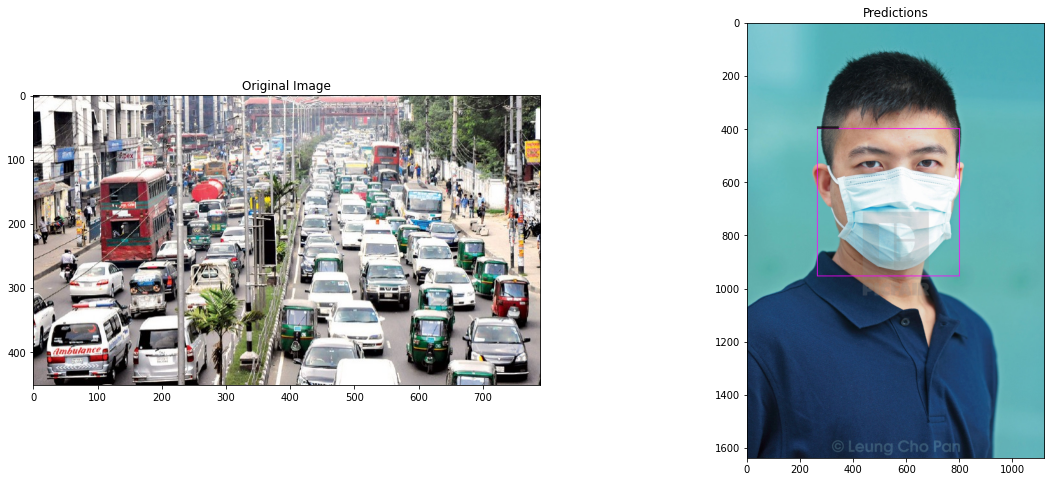

In [25]:
!/home/jeff/Documents/Code/darknet/darknet detector test yolov3-mask-setup.data yolov3-mask-test.cfg backup/yolov3-mask-train_best.weights /home/jeff/Documents/Code/YOLO-Mask-Detector/yolo_test/test-image1.jpg -thresh .6 2> /dev/null
display_output("test1.jpg")